In [1]:
import pandas as pd
import altair as alt
import numpy as np
import scipy.io
alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

### Specify the path to the folder that contains the MCA results

In [2]:
base_dir = '../io/output/'

### Specify the model ID used to generate the MCA file 

Typically the MCA output file is named as `MCA_modelID.mat`

In [3]:
model_id = 'toy_model'

### Specify the number of models in the ensemble

In [4]:
n_models = 5

### Load the data

In [5]:
file_in_MCA = f'{base_dir}MCA_{model_id}.mat'
file_in_mets = f'{base_dir}{model_id}_metsActive.dat'
file_in_rxns = f'{base_dir}{model_id}_rxnsActive.dat'
file_in_enzs = f'{base_dir}{model_id}_enzNames.dat'

### Get reaction, enzyme, and metabolite names

In [6]:
def get_name_list(file_in):
    
    name_list = []
    with open(file_in, 'r') as f_in:
        line = f_in.readline()
        line = f_in.readline()
        while line:          
            name_list.append(line[2:].strip())
            line = f_in.readline()

    return name_list

rxn_names = get_name_list(file_in_rxns)
enz_names = get_name_list(file_in_enzs)
met_names = get_name_list(file_in_mets)

### Get control coefficients median and interquartile range

In [7]:
def get_df_median(mat, key_name, id_col, col_names, row_names, n_models):
    
    try:
        df = pd.DataFrame(data=mat['mcaResults'][key_name].item())
        df.columns = col_names
    except ValueError:
        df = pd.DataFrame(data=mat['mcaResults'][key_name].item()[0])
        df.columns = col_names

    df[id_col] = np.tile(row_names, n_models)
    df_median = df.groupby(id_col).median()
    
    return df_median


def get_df_iqr(mat, key_name, id_col, col_names, row_names, n_models):
    
    try:
        df = pd.DataFrame(data=mat['mcaResults'][key_name].item())
        df.columns = col_names
    except ValueError:
        df = pd.DataFrame(data=mat['mcaResults'][key_name].item()[0])
        df.columns = col_names

    df[id_col] = np.tile(row_names, n_models)
   
    df_q2 = df.groupby(id_col).quantile(0.25)
    df_q4 = df.groupby(id_col).quantile(0.75)
    
    df_iqr = df_q4.subtract(df_q2)    

    return df_iqr



mat = scipy.io.loadmat(file_in_MCA, squeeze_me=True)

key_name = 'vControl'
id_col = 'rxns'
col_names = rxn_names
row_names = rxn_names
Cv_df_median = get_df_median(mat, key_name, id_col, col_names, row_names, n_models)
Cv_df_iqr = get_df_iqr(mat, key_name, id_col, col_names, row_names, n_models)

key_name = 'xControl'
id_col = 'mets'
col_names = rxn_names
row_names = met_names
Cx_df_median = get_df_median(mat, key_name, id_col, col_names, row_names, n_models)
Cx_df_iqr = get_df_iqr(mat, key_name, id_col, col_names, row_names, n_models)
    


### Define function to plot heatmaps with altair

In [8]:
def get_heatmaps(C_df_in, id_col):
    
    C_df = C_df_in
    
    C_df[id_col] = C_df.index
    C_df = C_df.melt(id_vars=[id_col], var_name='variable')
    
    Cx_in = alt.Chart(C_df).mark_rect().encode(
        x='variable:N',
        y=id_col,
        color=alt.Color('value:Q', scale=alt.Scale(scheme='redblue', domain=[1,-1])),
        tooltip='value:Q'
    ).properties(
        width=300,
        height=250
    )

    return Cx_in 

### Plot flux control coefficients median (on the left) and respective interquartile range (on the right)

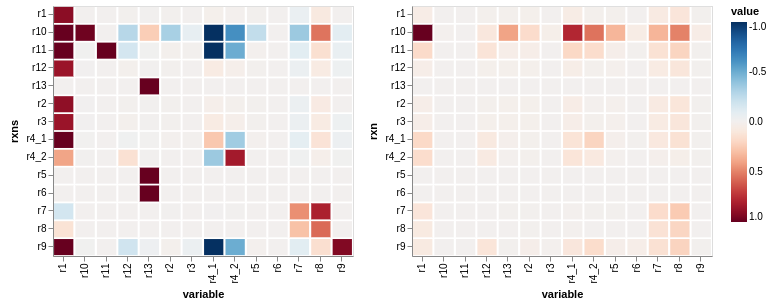

In [9]:
alt.hconcat(get_heatmaps(Cv_df_median, 'rxns'),
            get_heatmaps(Cv_df_iqr, 'rxn'))

### Plot concentration control coefficients median (on the left) and respective interquartile range (on the right)

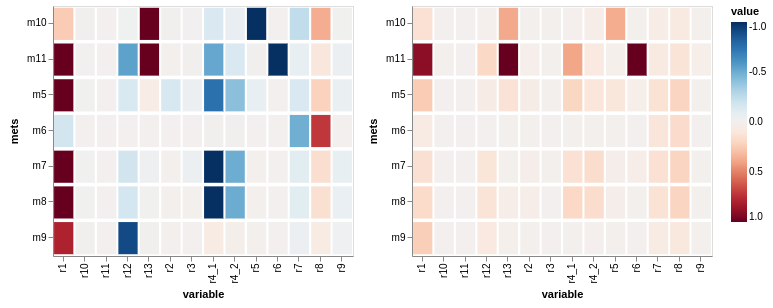

In [10]:
alt.hconcat(get_heatmaps(Cx_df_median, 'mets'),
            get_heatmaps(Cx_df_iqr, 'mets'))